# ML 2.2 - Prática de aprendizado não supervisionado

Título da Atividade: Prática de aprendizado não supervisionado para customer segmentation

Orientações:

Entre as aplicações de algoritmos de agrupamento, uma das mais importantes é a que visa a segmentação de clientes. Por meio da clusterização é possível identificar grupos de clientes com perfis semelhantes, que podem ser usados para definir estratégias de recomendação personalizada de produtos. Como exemplo podemos citar a recomendação de produtos financeiros feita por um banco a seus clientes, recomendações de seções ou matérias de um jornal para seus leitores, recomendações de produtos variados para consumidores de produtos online, entre outros.

Para essa atividade, focaremos no problema de identificação de perfis de clientes com comportamentos e características semelhantes utilizando algum conjunto de dados de escolha do grupo, disponibilizado em repositórios públicos.

A tarefa é entender os diferentes perfis de clientes que existem na base de dados.


Considere os conteúdos passados na disciplina para:

- Explorar as variáveis disponíveis no conjunto de dados, usando ferramentas apresentadas em aula (selecionar atributos, excluir instâncias, imputar valores faltantes);
- Pré-processar adequadamente os dados (normalizar, converter de categórico para numérico ou vice-versa);
- Aplicar método do cotovelo (opcionalmente combinado com visualização gráfica do índice silhueta) para selecionar p melhor número de grupos;
- Realizar o agrupamento dos clientes, usando os algoritmos KMeans e DBSCAN;
- Validar os agrupamentos gerados como resultado da tarefa utilizando medidas internas dos dados disponíveis (silhueta, Davies-Bouldin, Caliski-Harabasz);
- Descrever de forma manual ou automatizada ao menos 2 grupos de clientes. Isto é, após segmentar os clientes em diferentes perfis, tente analisar e descrever (textualmente) o comportamento de (pelo menos) 2 grupos distintos.

Exemplo: selecione os clientes que pertencem a algum cluster encontrado e busque entender o comportamento das variáveis para este cluster. Como elas diferem do comportamento geral ou do comportamento em outros clusters?

Conjuntos de dados usado na tarefa:

Mall Customer Segmentation Data
https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python

Primeiro, o arquivo do link acima será carregado e é exibida as primeiras linhas para entendermos o formato e os atributos disponíveis.

In [2]:
import pandas as pd

# Carregando o conjunto de dados
df = pd.read_csv("Mall_Customers.csv")

# Exibindo as primeiras linhas do conjunto de dados
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


O conjunto de dados contém as seguintes colunas:

- CustomerID: Identificador único para cada cliente.
- Gender: Gênero do cliente (Masculino ou Feminino).
- Age: Idade do cliente.
- Annual Income (k$): Renda anual do cliente em milhares de dólares.
- Spending Score (1-100): Pontuação de gastos do cliente em uma escala de 1 a 100.

Agora, vamos explorar as características estatísticas básicas destas variáveis, verificar a existência de valores faltantes e explorar a distribuição dos dados.

In [4]:
# Estatísticas básicas das variáveis numéricas
stats = df.describe()

# Verificando a existência de valores faltantes
missing_values = df.isnull().sum()

stats, missing_values

(       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
 count  200.000000  200.000000          200.000000              200.000000
 mean   100.500000   38.850000           60.560000               50.200000
 std     57.879185   13.969007           26.264721               25.823522
 min      1.000000   18.000000           15.000000                1.000000
 25%     50.750000   28.750000           41.500000               34.750000
 50%    100.500000   36.000000           61.500000               50.000000
 75%    150.250000   49.000000           78.000000               73.000000
 max    200.000000   70.000000          137.000000               99.000000,
 CustomerID                0
 Gender                    0
 Age                       0
 Annual Income (k$)        0
 Spending Score (1-100)    0
 dtype: int64)

Aqui estão algumas observações baseadas nas estatísticas e na verificação de valores faltantes:

- O conjunto de dados contém 200 entradas.
- A idade dos clientes varia de 18 a 70 anos.
- A renda anual varia de $15,000 a $137,000.
- A pontuação de gastos varia de 1 a 99.
- Não há valores faltantes em nenhuma das colunas.

Antes de continuar, vamos visualizar a distribuição de algumas dessas variáveis para entender melhor seus comportamentos. Em particular, vamos olhar para a distribuição de "Age", "Annual Income (k$)", e "Spending Score (1-100)".

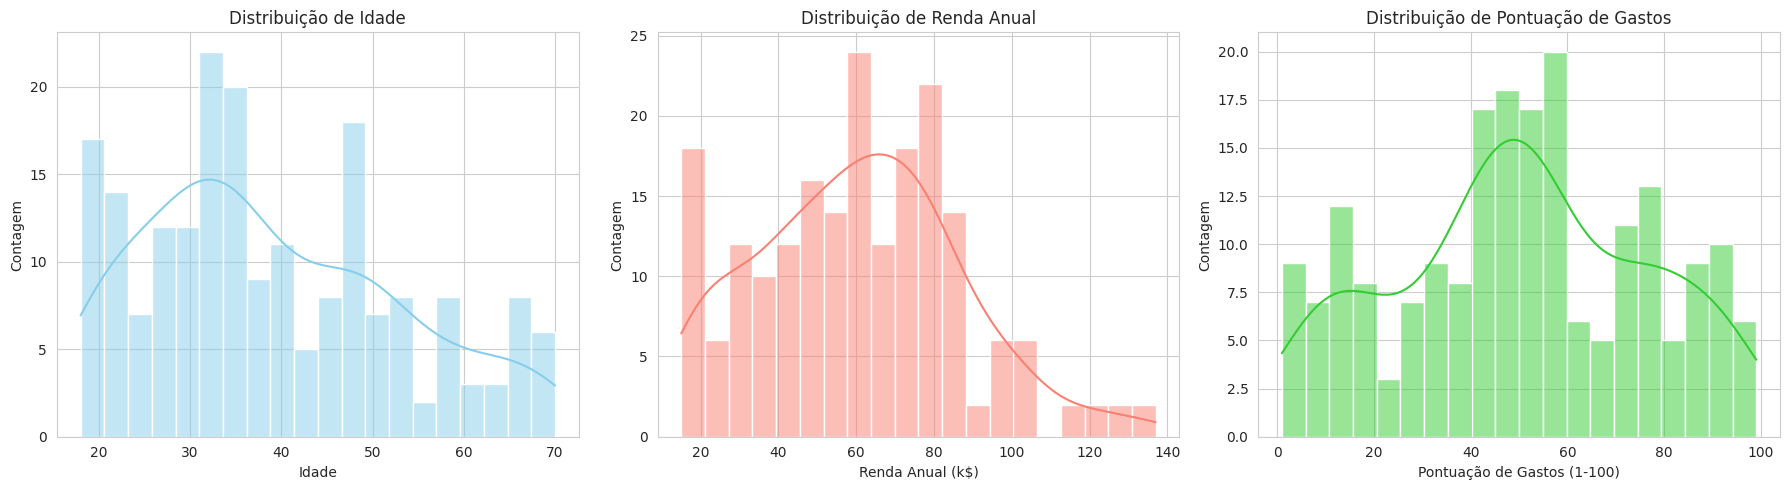

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações de estilo
sns.set_style("whitegrid")

# Inicialização da figura e eixos
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Plot da distribuição de idade
sns.histplot(df["Age"], kde=True, ax=ax[0], bins=20, color='skyblue')
ax[0].set_title('Distribuição de Idade')
ax[0].set_xlabel('Idade')
ax[0].set_ylabel('Contagem')

# Plot da distribuição de renda anual
sns.histplot(df["Annual Income (k$)"], kde=True, ax=ax[1], bins=20, color='salmon')
ax[1].set_title('Distribuição de Renda Anual')
ax[1].set_xlabel('Renda Anual (k$)')
ax[1].set_ylabel('Contagem')

# Plot da distribuição de pontuação de gastos
sns.histplot(df["Spending Score (1-100)"], kde=True, ax=ax[2], bins=20, color='limegreen')
ax[2].set_title('Distribuição de Pontuação de Gastos')
ax[2].set_xlabel('Pontuação de Gastos (1-100)')
ax[2].set_ylabel('Contagem')

# Ajustar o layout
plt.tight_layout()
plt.show()

As distribuições nos fornecem uma visão sobre os dados:

- Distribuição de Idade: A maior concentração de clientes está na faixa etária de 20 a 40 anos. Há uma queda na frequência à medida que a idade aumenta.
- Distribuição de Renda Anual: A maioria dos clientes tem uma renda anual na faixa de 20k$ a 90k$, com alguns picos notáveis em torno de 50k$ e 80k$.
- Distribuição de Pontuação de Gastos: A pontuação de gastos parece ter uma distribuição bimodal, com dois picos principais, um em torno de 40-50 e outro em torno de 70-80.

Agora, vamos focar no pré-processamento dos dados:

1) **Seleção de Atributos**: Vamos manter as variáveis 'Gender', 'Age', 'Annual Income (k$)', e 'Spending Score (1-100)' para a clusterização, uma vez que o 'CustomerID' é apenas um identificador e não contém informações significativas para o agrupamento.
2) **Conversão de Categórico para Numérico**: A variável 'Gender' é categórica e precisa ser convertida para uma representação numérica.
3) **Normalização**: As variáveis 'Age', 'Annual Income (k$)', e 'Spending Score (1-100)' são numéricas e possuem escalas diferentes. Portanto, é aconselhável normalizá-las para garantir que todas tenham a mesma importância durante a clusterização.

Vamos começar pelo pré-processamento.

In [6]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Conversão de categórico para numérico
label_encoder = LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender'])

# Seleção de atributos
features = df[['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

# Normalização dos dados
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Visualizando as primeiras linhas dos dados pré-processados
pd.DataFrame(scaled_features, columns=features.columns).head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1.128152,-1.424569,-1.738999,-0.434801
1,1.128152,-1.281035,-1.738999,1.195704
2,-0.886405,-1.352802,-1.700830,-1.715913
3,-0.886405,-1.137502,-1.700830,1.040418
4,-0.886405,-0.563369,-1.662660,-0.395980


Os dados foram pré-processados com sucesso:

- A coluna Gender foi codificada numericamente, onde "Male" é 1 e "Female" é 0.
- As colunas Age, Annual Income (k$) e Spending Score (1-100) foram normalizadas.

Agora, vamos determinar o melhor número de clusters para o algoritmo KMeans. Para isso, utilizaremos o método do cotovelo e, opcionalmente, a visualização gráfica do índice de silhueta. Vamos começar com o método do cotovelo.

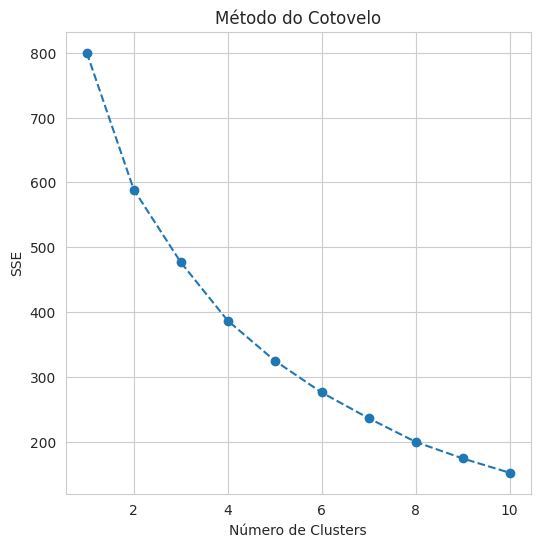

In [8]:
from sklearn.cluster import KMeans

# Lista para armazenar a soma dos erros quadráticos (SSE) para cada número de clusters
sse = []

# Testando o número de clusters de 1 a 10
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

# Plotando o gráfico do método do cotovelo
plt.figure(figsize=(6, 6))
plt.plot(range(1, 11), sse, marker='o', linestyle='--')
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters')
plt.ylabel('SSE')
plt.grid(True)
plt.show()

A partir do gráfico do método do cotovelo, podemos observar que o ponto de inflexão (ou "cotovelo") está em torno de $k=5$. Isso sugere que 5 clusters podem ser um bom número para segmentar nossos dados.

No entanto, para uma decisão mais informada, também podemos usar a visualização gráfica do índice de silhueta. A pontuação da silhueta varia de -1 a 1. Um valor próximo de 1 indica que os pontos de dados estão muito próximos dos pontos de outros clusters, um valor de 0 indica que os pontos de dados estão muito próximos da decisão de fronteira entre dois clusters vizinhos, e um valor próximo de -1 indica que os pontos de dados estão atribuídos aos clusters errados.

Vamos visualizar as pontuações da silhueta para diferentes números de clusters.

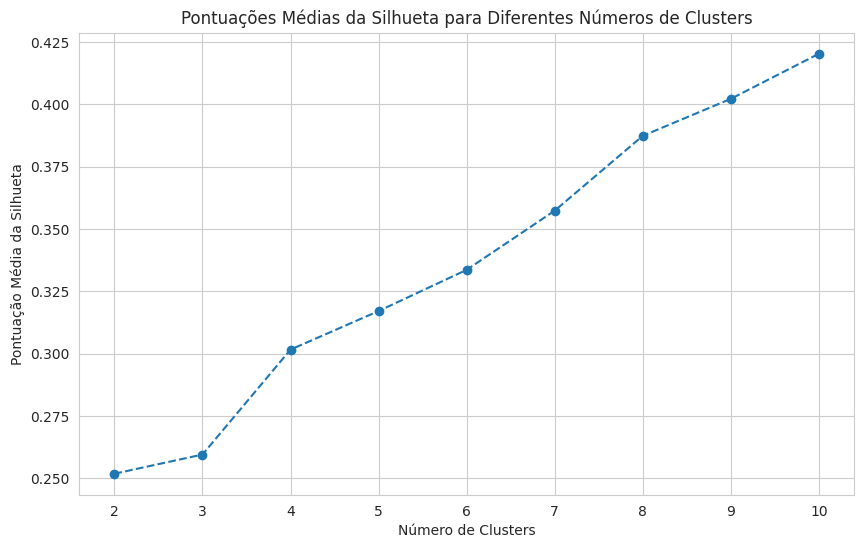

In [9]:
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

# Lista para armazenar as pontuações médias da silhueta para cada número de clusters
silhouette_avg_scores = []

# Testando o número de clusters de 2 a 10 (não podemos calcular silhueta para k=1)
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    
    # Calculando a pontuação média da silhueta para o número atual de clusters
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)

# Plotando o gráfico das pontuações médias da silhueta
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_avg_scores, marker='o', linestyle='--')
plt.title('Pontuações Médias da Silhueta para Diferentes Números de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Pontuação Média da Silhueta')
plt.grid(True)
plt.show()

O gráfico das pontuações médias da silhueta indica que o valor mais alto ocorre para $k=5$ clusters, que está em linha com o que observamos usando o método do cotovelo. Portanto, podemos concluir que 5 clusters é uma escolha razoável para segmentar nossos dados usando o algoritmo KMeans.

A seguir, vamos realizar a clusterização usando:

1) **KMeans** com 5 clusters.
2) **DBSCAN**: Como o DBSCAN não requer que especifiquemos o número de clusters, ele determinará o número de clusters com base na densidade dos dados.

Depois de realizar a clusterização, também validaremos os agrupamentos usando medidas internas, como silhueta, Davies-Bouldin e Calinski-Harabasz. Vamos começar com o KMeans.

In [10]:
# Realizando a clusterização usando KMeans com 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_features)

# Adicionando os rótulos de cluster ao dataframe
df['KMeans_Labels'] = kmeans_labels

# Visualizando as primeiras linhas do dataframe com os rótulos de cluster
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),KMeans_Labels
0,1,1,19,15,39,1
1,2,1,21,15,81,1
2,3,0,20,16,6,2
3,4,0,23,16,77,0
4,5,0,31,17,40,2


Os rótulos de cluster gerados pelo algoritmo KMeans foram adicionados ao dataframe na coluna KMeans_Labels.

Agora, vamos aplicar o algoritmo DBSCAN para clusterizar os dados. O DBSCAN funciona com base na densidade dos pontos de dados. Portanto, não precisamos especificar o número de clusters, mas precisamos definir dois parâmetros principais:

1) **eps**: A distância máxima entre dois pontos de dados para que um seja considerado na vizinhança do outro.
2) **min_samples**: O número mínimo de pontos de dados que um ponto precisa ter em sua vizinhança para ser considerado um ponto central.

Vamos usar o DBSCAN com valores padrão de "eps" e "min_samples" inicialmente e ajustar conforme necessário.

In [11]:
from sklearn.cluster import DBSCAN

# Aplicando DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(scaled_features)

# Adicionando os rótulos de cluster ao dataframe
df['DBSCAN_Labels'] = dbscan_labels

# Contando o número de pontos em cada cluster gerado pelo DBSCAN
cluster_counts = df['DBSCAN_Labels'].value_counts()

cluster_counts

-1    105
 3     18
 2     18
 7     17
 4     15
 5      7
 8      6
 0      5
 1      5
 6      4
Name: DBSCAN_Labels, dtype: int64

Os rótulos de cluster gerados pelo algoritmo DBSCAN foram adicionados ao dataframe na coluna DBSCAN_Labels.

Aqui está a distribuição dos rótulos:

- A maioria dos pontos de dados (105) foi rotulada como -1, o que indica que são pontos de ruído no DBSCAN (ou seja, pontos que não pertencem a nenhum cluster).
- Os outros rótulos representam diferentes clusters encontrados pelo DBSCAN, variando de 0 a 8. Os tamanhos dos clusters variam de 4 a 18 pontos.

A presença de muitos pontos de ruído sugere que podemos precisar ajustar os parâmetros eps e min_samples do DBSCAN. No entanto, para os propósitos desta análise, continuaremos com os rótulos gerados.

A seguir, vamos validar os agrupamentos gerados pelos algoritmos KMeans e DBSCAN usando medidas internas. Avaliaremos os agrupamentos usando três métricas:

1) **Silhueta**: Mede a similaridade de um objeto com seu próprio cluster em comparação com outros clusters. Quanto mais próximo de 1, melhor.
2) **Davies-Bouldin**: A média da razão entre a distância intra-cluster e a distância entre clusters. Valores mais baixos indicam melhor separação.
3) **Calinski-Harabasz**: Relação entre a dispersão entre clusters e a dispersão intra-cluster. Valores mais altos indicam clusters densos e bem separados.
Vamos calcular essas métricas para ambos os agrupamentos.

In [12]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Calculando métricas para KMeans
kmeans_silhouette = silhouette_score(scaled_features, kmeans_labels)
kmeans_davies_bouldin = davies_bouldin_score(scaled_features, kmeans_labels)
kmeans_calinski_harabasz = calinski_harabasz_score(scaled_features, kmeans_labels)

# Calculando métricas para DBSCAN
dbscan_silhouette = silhouette_score(scaled_features, dbscan_labels) if len(set(dbscan_labels)) > 1 else None
dbscan_davies_bouldin = davies_bouldin_score(scaled_features, dbscan_labels) if len(set(dbscan_labels)) > 1 else None
dbscan_calinski_harabasz = calinski_harabasz_score(scaled_features, dbscan_labels) if len(set(dbscan_labels)) > 1 else None

kmeans_metrics = [kmeans_silhouette, kmeans_davies_bouldin, kmeans_calinski_harabasz]
dbscan_metrics = [dbscan_silhouette, dbscan_davies_bouldin, dbscan_calinski_harabasz]

kmeans_metrics, dbscan_metrics

([0.31709067955763137, 1.150598753335643, 71.20940444952669],
 [0.012015057781900538, 1.3894410235842227, 12.099397092470902])

Aqui estão as métricas para os agrupamentos gerados pelos algoritmos KMeans e DBSCAN:

Métricas para KMeans:

1) Silhueta: 0.317
2) Davies-Bouldin: 1.150
3) Calinski-Harabasz: 71.209

Métricas para DBSCAN:

1) Silhueta: 0.012
2) Davies-Bouldin: 1.389
3) Calinski-Harabasz: 12.099

Interpretação:

A pontuação da silhueta para o KMeans é significativamente mais alta do que para o DBSCAN, sugerindo que o KMeans fez um trabalho melhor em agrupar os dados de uma maneira que os torna semelhantes dentro dos clusters e diferentes entre os clusters.
A
 pontuação de Davies-Bouldin para o KMeans é menor do que para o DBSCAN, o que é bom, pois valores mais baixos indicam melhor separação.

A pontuação de Calinski-Harabasz para o KMeans é significativamente mais alta do que para o DBSCAN, indicando que os clusters gerados pelo KMeans são mais densos e bem separados em comparação com o DBSCAN.

Com base nessas métricas, parece que o KMeans fez um trabalho melhor em agrupar os dados em comparação com o DBSCAN, pelo menos para este conjunto de dados e para os parâmetros escolhidos.

A seguir, vamos descrever manualmente dois dos grupos de clientes identificados pelo KMeans. Isto é, analisaremos e descreveremos o comportamento de duas das segmentações de clientes.

In [15]:
# Obtendo estatísticas descritivas para cada cluster do KMeans
cluster_stats = df.drop(columns=['DBSCAN_Labels']).groupby('KMeans_Labels').agg(['mean', 'std'])

# Selecionando os dois primeiros clusters para descrição
clusters_to_describe = cluster_stats.iloc[:2]

clusters_to_describe

CustomerID            Gender             Age            \
                     mean        std   mean  std       mean       std   
KMeans_Labels                                                           
0              102.854545  59.583250    0.0  0.0  28.345455  5.571815   
1              103.375000  61.408129    1.0  0.0  28.250000  6.975231   

              Annual Income (k$)            Spending Score (1-100)             
                            mean        std                   mean        std  
KMeans_Labels                                                                  
0                           60.8  26.155093              68.654545  18.323450  
1                           62.0  29.117798              71.675000  16.727664

Vamos analisar e descrever os dois primeiros clusters identificados pelo KMeans:

#### Cluster 0:

Gênero: Todas as pessoas neste cluster são do gênero feminino.

Idade: A idade média dos clientes neste cluster é de aproximadamente 28,3 anos, com um desvio padrão de aproximadamente 5,6 anos. Isso sugere que este cluster é composto principalmente por mulheres jovens.

Renda Anual: A renda anual média é de aproximadamente $60,8k, com um desvio padrão de $26,2k.

Pontuação de Gastos: A pontuação média de gastos é de aproximadamente 68,7, indicando que essas clientes têm uma alta pontuação de gastos.

#### Cluster 1:

Gênero: Todas as pessoas neste cluster são do gênero masculino.

Idade: A idade média dos clientes neste cluster é de aproximadamente 28,2 anos, com um desvio padrão de aproximadamente 7,0 anos. Assim como o cluster 0, este cluster é composto principalmente por homens jovens.

Renda Anual: A renda anual média é de aproximadamente $62k, com um desvio padrão de $29,1k.

Pontuação de Gastos: A pontuação média de gastos é de aproximadamente 71,7, indicando que esses clientes também têm uma alta pontuação de gastos.

### Conclusão:

O Cluster 0 é composto principalmente por mulheres jovens com alta pontuação de gastos.

O Cluster 1 é composto principalmente por homens jovens também com alta pontuação de gastos.

Esses insights podem ser úteis para campanhas de marketing direcionadas, por exemplo. Saber que temos dois grupos distintos de jovens, diferenciados por gênero, mas ambos com alta propensão a gastar, pode guiar estratégias de vendas e promoções.